In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
df = pd.read_csv("data_insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
# Checking for missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Exploratory Data Analysis

<Axes: xlabel='charges', ylabel='Count'>

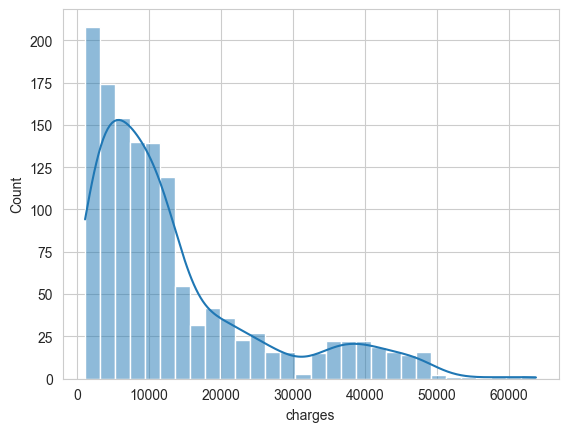

In [6]:
sns.histplot(data=df, x='charges', kde=True)

<Axes: xlabel='charges'>

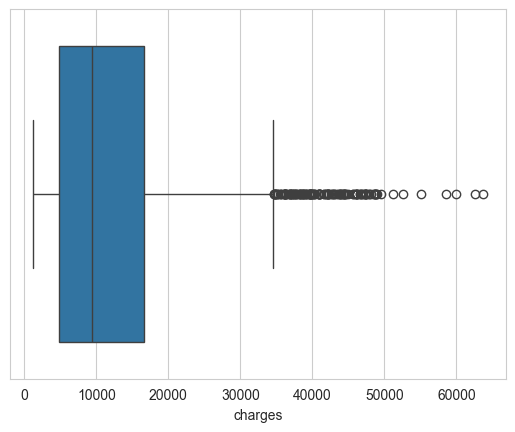

In [7]:
sns.boxplot(data=df, x='charges')

In [8]:
# Outlier detection and removal
# Q1 = df['charges'].quantile(0.25)
# Q3 = df['charges'].quantile(0.75)

# IQR = Q3 - Q1
# upper_fence = Q3 + 1.5*IQR
# lower_fence = Q1 - 1.5*IQR

# df = df[(df['charges'] >= lower_fence) & (df['charges'] <= upper_fence)]

## Feature Engineering

In [9]:
# Feature Engineering
df['bmi_age_interaction'] = df['bmi'] * df['age']
df['smoker_bmi_interaction'] = df['bmi'] * (df['smoker'] == 'yes').astype(int)
df['smoker_age_interaction'] = df['age'] * (df['smoker'] == 'yes').astype(int)
df['children_age_interaction'] = df['children'] * df['age']

def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif bmi < 25:
        return 'normal'
    elif bmi < 30:
        return 'overweight'
    else:
        return 'obese'

df['bmi_category'] = df['bmi'].apply(categorize_bmi)

# Age groups
def categorize_age(age):
    if age < 25:
        return 'young'
    elif age < 40:
        return 'middle_young'
    elif age < 55:
        return 'middle_old'
    else:
        return 'old'

df['age_category'] = df['age'].apply(categorize_age)
df['high_risk_smoker'] = ((df['smoker'] == 'yes') & (df['bmi'] >= 30)).astype(int)
df['elderly_smoker'] = ((df['smoker'] == 'yes') & (df['age'] >= 50)).astype(int)

In [10]:
X = df.drop(columns=["charges"])
y = df['charges']

## Model Building & Evaluation 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

numerical_features = [
    'age', 'bmi', 'children',
    'bmi_age_interaction', 'smoker_bmi_interaction',
    'smoker_age_interaction', 'children_age_interaction',
    'high_risk_smoker', 'elderly_smoker'
]

categorical_features = ['sex', 'smoker', 'region', 'bmi_category', 'age_category']

preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print("\n" + "="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)
print(f"Training R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")
print(f"Training MSE: {train_mse:,.2f}")
print(f"Test MSE: {test_mse:,.2f}")
print(f"Training RMSE: {train_rmse:,.2f}")
print(f"Test RMSE: {test_rmse:,.2f}")


MODEL EVALUATION RESULTS
Training R² Score: 0.8695
Test R² Score: 0.8684
Training MSE: 18,937,580.69
Test MSE: 19,850,697.11
Training RMSE: 4,351.73
Test RMSE: 4,455.41


In [12]:
feature_names = (numerical_features + 
                list(pipeline.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out()))

coefficients = pipeline.named_steps['model'].coef_
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print(feature_importance[:10])

                    feature  coefficient  abs_coefficient
15  bmi_category_overweight  5661.943186      5661.943186
18         age_category_old  4844.171569      4844.171569
11         region_northwest  3781.533279      3781.533279
10               smoker_yes  2283.587693      2283.587693
7          high_risk_smoker -1464.320419      1464.320419
1                       bmi  1444.573792      1444.573792
4    smoker_bmi_interaction -1330.455293      1330.455293
13         region_southwest   750.756421       750.756421
3       bmi_age_interaction  -742.255681       742.255681
14       bmi_category_obese   678.202289       678.202289
